<a href="https://www.kaggle.com/code/marygamal/breakhis-notebook?scriptVersionId=270505894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/

In [2]:
import os
import re
import random
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


2025-10-24 10:16:04.597305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761300964.854874      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761300964.928447      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Build dataframe of images

In [3]:
base_input = Path('/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast')
image_paths = sorted([str(p) for p in base_input.rglob('*.png')])

len(image_paths)


7909

# Parse label, magnification, patient id

In [4]:
def parse_breakhis_path(p: str):
    # Example path segment: .../benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
    fname = os.path.basename(p)
    parts = fname.split('_')
    # label: presence of 'B' or 'M' in the filename (second underscore piece in example)
    label_token = parts[1] if len(parts) > 1 else ''
    label = 'benign' if label_token.upper().startswith('B') else 'malignant'
    # magnification is usually parent folder name like '200X', '40X'
    mag = Path(p).parents[0].name  # immediate parent folder like '200X'
    # patient id: third underscore piece typically includes patient and magnification numbers:
    # e.g. 'A-14-29960CD-200-012.png' -> take the chunk before the last two '-' parts
    try:
        third = parts[2]
        patient = third.rsplit('-', 2)[0]  # 'A-14-29960CD'
    except Exception:
        # fallback: attempt regex to capture pattern like A-14-29960CD
        m = re.search(r'([A-Za-z]-\d+-\w+)', fname)
        patient = m.group(1) if m else fname
    return label, mag, patient

rows = []
for p in image_paths:
    label, mag, patient = parse_breakhis_path(p)
    rows.append({'filepath': p, 'label': label, 'mag': mag, 'patient_id': patient})
df = pd.DataFrame(rows)
# Normalize magnification strings (some may be '40X' or '040X')
df['mag'] = df['mag'].str.upper().str.replace(' ', '')
df = df[df['mag'].isin(['40X', '200X'])].reset_index(drop=True)  # keep only 40x and 200x
print("Total images (40x and 200x):", len(df))
df.sample(5)



Total images (40x and 200x): 4008


,filepath,label,mag,patient_id
2580,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,200X,DC-14-2985
3659,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,200X,MC-14-19979
897,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,benign,40X,PT-14-22704
2091,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,40X,DC-14-16875
1044,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,benign,200X,TA-14-16184


# Split by patient into train/val/test


In [5]:
#Split by patient into train/val/test
def patient_stratified_split(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=SEED):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
    splits = {}
    for mag in df['mag'].unique():
        sub = df[df['mag']==mag].copy()
        patients = sub['patient_id'].unique().tolist()
        random.Random(seed).shuffle(patients)
        n = len(patients)
        n_train = int(round(train_frac * n))
        n_val = int(round(val_frac * n))
        train_pat = set(patients[:n_train])
        val_pat = set(patients[n_train:n_train+n_val])
        test_pat = set(patients[n_train+n_val:])
        splits[mag] = {
            'train': sub[sub['patient_id'].isin(train_pat)],
            'val': sub[sub['patient_id'].isin(val_pat)],
            'test': sub[sub['patient_id'].isin(test_pat)]
        }
    return splits

splits = patient_stratified_split(df, 0.7, 0.1, 0.2)
for mag in splits:
    print(mag, {k: len(v) for k,v in splits[mag].items()})
splits = patient_stratified_split(df, 0.7, 0.1, 0.2)

200X {'train': 1329, 'val': 173, 'test': 511}
40X {'train': 1350, 'val': 191, 'test': 454}


In [6]:
for mag in splits:
    print(f"\n=== {mag} ===")
    for split_name, split_df in splits[mag].items():
        n_images = len(split_df)
        n_patients = split_df['patient_id'].nunique()
        print(f"{split_name:>5} | images: {n_images:4d} | patients: {n_patients:3d}")



=== 200X ===
train | images: 1329 | patients:  57
  val | images:  173 | patients:   8
 test | images:  511 | patients:  17

=== 40X ===
train | images: 1350 | patients:  57
  val | images:  191 | patients:   8
 test | images:  454 | patients:  17


# dataset creation, augmentation

In [7]:
#dataset creation, augmentation
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Running on:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")



Num GPUs Available: 2
Running on: GPU


In [8]:
IMG_SIZE = (224, 224)  # MobileNet expects 224x224; we will use the same for custom CNN 
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = ['benign', 'malignant']
# helper to make label map
label_to_idx = {c:i for i,c in enumerate(CLASS_NAMES)}
def path_to_tensor(path, img_size=IMG_SIZE, preprocess=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    if preprocess is not None:
        img = preprocess(img)
    else:
        img = img / 255.0
    return img

# augmentation function using Keras layers (applied in model or dataset)
data_augment = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05, 0.05),
])

def df_to_tf_dataset(df, preprocess=None, shuffle=False, repeat=False):
    paths = df['filepath'].values
    labels = [label_to_idx[l] for l in df['label'].values]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    def _load(path, label):
        img = path_to_tensor(path, IMG_SIZE, preprocess)
        return img, label
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


I0000 00:00:1761300979.930163      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761300979.931248      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Model builders (Custom CNN + MobileNet

In [9]:
def build_custom_cnn(input_shape=(*IMG_SIZE,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)  # Add dropout
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)  # Increase dense units
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='custom_cnn')
    return model

def build_mobilenet_v2(input_shape=(*IMG_SIZE,3), num_classes=2, trainable_base=False):
    inputs = layers.Input(shape=input_shape)
    # Removed Rescaling here; will use preprocess_input in dataset
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')
    base.trainable = trainable_base
    x = base(inputs, training=False)  # Pass inputs directly
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='mobilenet_v2_tl')
    return model

# Training loop 

In [10]:
#Training loop
def compile_and_train(model, train_ds, val_ds, epochs=20, model_name='model', patience=4):
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    checkpoint_cb = callbacks.ModelCheckpoint(f'{model_name}.h5', save_best_only=True, monitor='val_loss')
    early_cb = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=[checkpoint_cb, early_cb, reduce_cb])
    return history

In [11]:
# Loop over magnifications (40X and 200X)
mag = '40X'
print(f"\n{'='*50}\nProcessing {mag}\n{'='*50}")
train_df = splits[mag]['train'].reset_index(drop=True)
val_df   = splits[mag]['val'].reset_index(drop=True)
test_df  = splits[mag]['test'].reset_index(drop=True)
print("Counts:", len(train_df), len(val_df), len(test_df))
    
 # Custom CNN datasets (no special preprocess)
train_ds = df_to_tf_dataset(train_df, preprocess=None, shuffle=True, repeat=False)
val_ds   = df_to_tf_dataset(val_df, preprocess=None, shuffle=False)
test_ds  = df_to_tf_dataset(test_df, preprocess=None, shuffle=False)
    # MobileNet datasets (with preprocess)
train_ds_mob = df_to_tf_dataset(train_df, preprocess=mobilenet_preprocess, shuffle=True, repeat=False)
val_ds_mob   = df_to_tf_dataset(val_df, preprocess=mobilenet_preprocess, shuffle=False)
test_ds_mob  = df_to_tf_dataset(test_df, preprocess=mobilenet_preprocess, shuffle=False)
    # Build and train custom cnn
custom_cnn = build_custom_cnn()
custom_history = compile_and_train(custom_cnn, train_ds, val_ds, epochs=50, model_name=f'custom_cnn_{mag.lower()}')

 # Build and train MobileNetV2 (transfer learning)
mobilenet = build_mobilenet_v2(trainable_base=False)
mobilenet_history = compile_and_train(mobilenet, train_ds_mob, val_ds_mob, epochs=15, model_name=f'mobilenet_{mag.lower()}')
    # Optional: unfreeze some layers and fine-tune
mobilenet.trainable = True
    # Freeze first N layers if you want
for layer in mobilenet.layers[:-20]:
    layer.trainable = False
mobilenet_history_ft = compile_and_train(mobilenet, train_ds_mob, val_ds_mob, epochs=10, model_name=f'mobilenet_{mag.lower()}_finetuned', patience=3)



Processing 40X
Counts: 1350 191 454
Epoch 1/50


E0000 00:00:1761300987.868635      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_cnn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761300990.120401     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.7110 - loss: 0.5983 - val_accuracy: 1.0000 - val_loss: 0.6313 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7920 - loss: 0.5145 - val_accuracy: 1.0000 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7936 - loss: 0.4477 - val_accuracy: 1.0000 - val_loss: 0.5685 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8163 - loss: 0.4314 - val_accuracy: 1.0000 - val_loss: 0.4793 - learning_rate: 1.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8451 - loss: 0.3853 - val_accuracy: 1.0000 - val_loss: 0.4567 - learning_rate: 1.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8468 - loss: 0.3692 - val_accuracy: 1.0000 - val_loss: 0.3451 - learning_rate: 1.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8378 - l

I0000 00:00:1761301072.541448      99 service.cc:148] XLA service 0x7bd8f81b8fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761301072.543535      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761301072.543555      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 5/43 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5610 - loss: 0.7923

I0000 00:00:1761301077.130239      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - accuracy: 0.6467 - loss: 0.6657 - val_accuracy: 0.9005 - val_loss: 0.3499 - learning_rate: 1.0000e-04
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.8248 - loss: 0.4334 - val_accuracy: 0.9005 - val_loss: 0.3317 - learning_rate: 1.0000e-04
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.8587 - loss: 0.3524 - val_accuracy: 0.8586 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8956 - loss: 0.2927 - val_accuracy: 0.8796 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9254 - loss: 0.2445 - val_accuracy: 0.8429 - val_loss: 0.3839 - learning_rate: 1.0000e-04
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9358 - loss: 0.2267 - val_accuracy: 0.8534 - val_loss: 0.3543 - learning_rate: 1.0000e-04
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9360 - l

In [12]:
def evaluate_and_report(model, df_test, preprocess=None):
        ds = df_to_tf_dataset(df_test, preprocess=preprocess, shuffle=False)
        preds = model.predict(ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = [label_to_idx[l] for l in df_test['label'].values]
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
        cm = confusion_matrix(y_true, y_pred)
        return cm, y_true, y_pred
print(f"Custom CNN ({mag}) evaluation:")
cm_custom, y_true_custom, y_pred_custom = evaluate_and_report(custom_cnn, test_df)
print(f"MobileNet ({mag}) evaluation:")
cm_mobilenet, y_true_mob, y_pred_mob = evaluate_and_report(mobilenet, test_df, preprocess=mobilenet_preprocess)


Custom CNN (40X) evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
              precision    recall  f1-score   support

      benign       1.00      0.03      0.07       172
   malignant       0.63      1.00      0.77       282

    accuracy                           0.63       454
   macro avg       0.81      0.52      0.42       454
weighted avg       0.77      0.63      0.51       454

MobileNet (40X) evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step
              precision    recall  f1-score   support

      benign       0.71      0.58      0.64       172
   malignant       0.77      0.86      0.81       282

    accuracy                           0.75       454
   macro avg       0.74      0.72      0.73       454
weighted avg       0.75      0.75      0.75       454



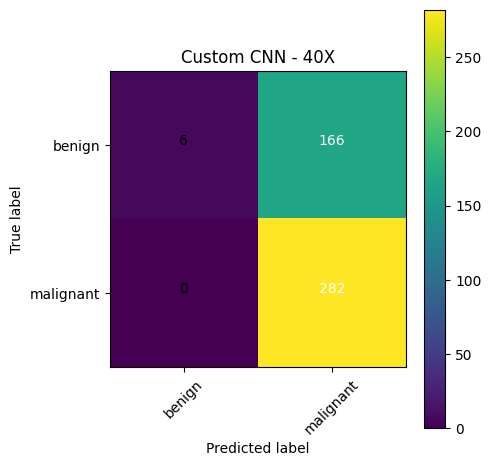

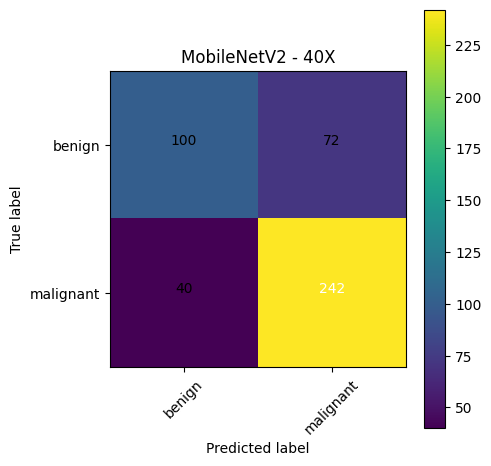

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
        plt.figure(figsize=(5,5))
        plt.imshow(cm, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
plot_confusion_matrix(cm_custom, CLASS_NAMES, title=f'Custom CNN - {mag}')
plot_confusion_matrix(cm_mobilenet, CLASS_NAMES, title=f'MobileNetV2 - {mag}')


Custom CNN Training History (40X):


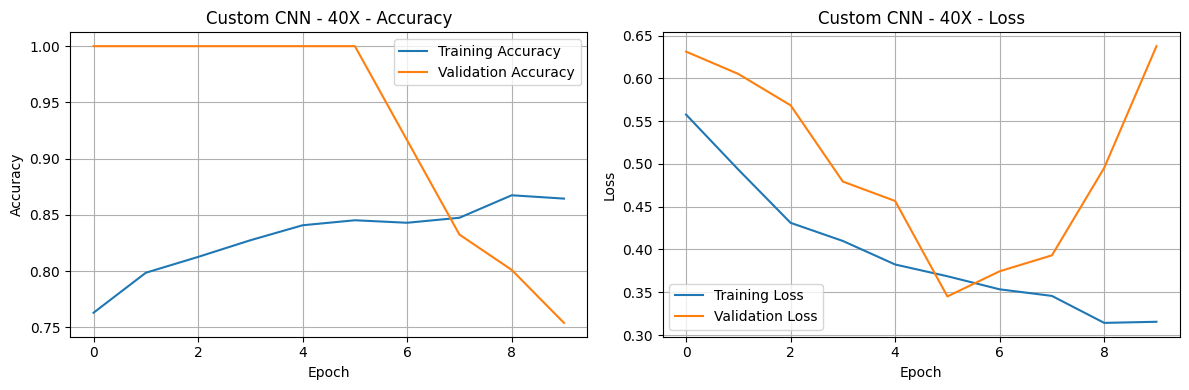

MobileNetV2 Training History (40X):


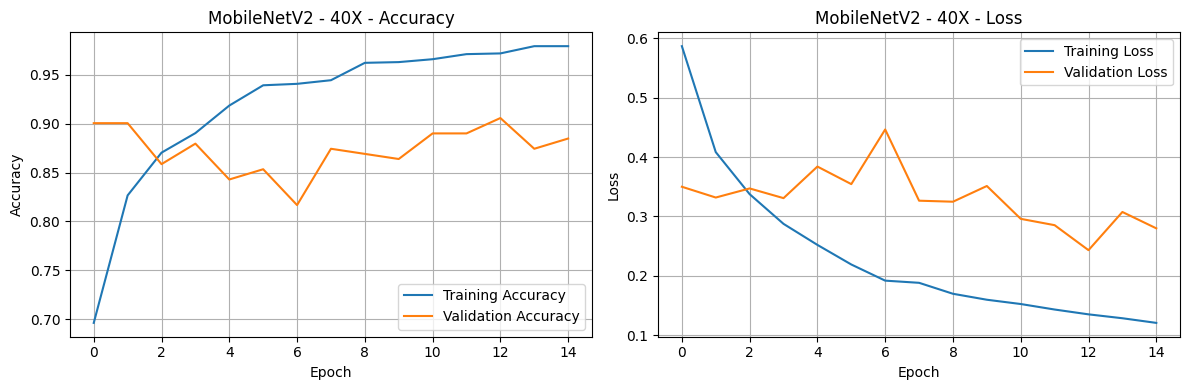

MobileNetV2 Fine-tuned Training History (40X):


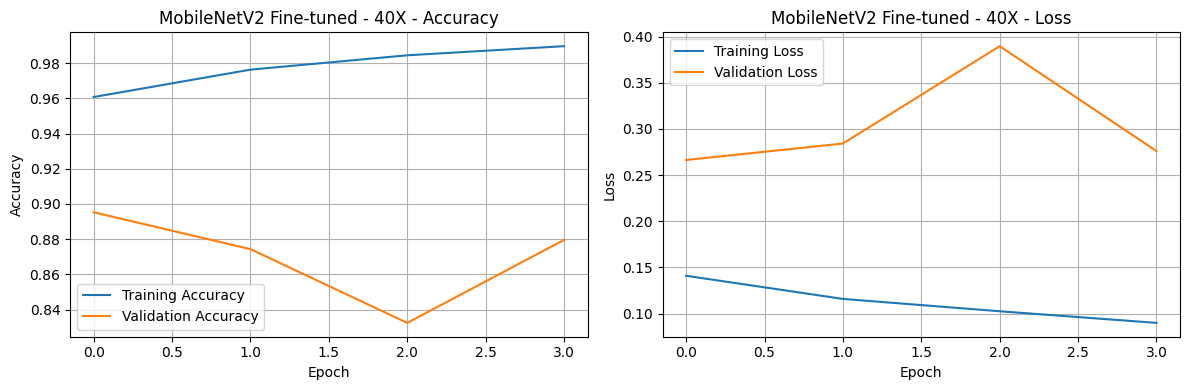

In [14]:
# Function to plot training history
def plot_training_history(history, model_name='Model'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot training & validation accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{model_name} - Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot training & validation loss
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{model_name} - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
# Plot for Custom CNN
print(f"Custom CNN Training History ({mag}):")
plot_training_history(custom_history, f'Custom CNN - {mag}')
# Plot for MobileNetV2
print(f"MobileNetV2 Training History ({mag}):")
plot_training_history(mobilenet_history, f'MobileNetV2 - {mag}')
# Plot for MobileNetV2 Fine-tuned
print(f"MobileNetV2 Fine-tuned Training History ({mag}):")
plot_training_history(mobilenet_history_ft, f'MobileNetV2 Fine-tuned - {mag}')
